In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

,f0,f1,f2,f3,f4,f5,f6,choice
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.499075,0.499574,0.500833,0.500979,0.500148,0.499945,0.500528,0.998750
std,0.289398,0.289923,0.288570,0.290778,0.290288,0.288353,0.289760,0.818219
min,0.000032,0.000170,0.000184,0.000098,0.000037,0.000077,0.000036,0.000000
25%,0.247563,0.248755,0.252640,0.248971,0.248868,0.250270,0.247768,0.000000
50%,0.499971,0.500040,0.499997,0.499995,0.499979,0.499992,0.500100,1.000000
75%,0.750222,0.750021,0.752009,0.754630,0.753584,0.749569,0.750813,2.000000
max,0.999979,0.999908,0.999994,0.999987,0.999984,0.999980,0.999982,2.000000


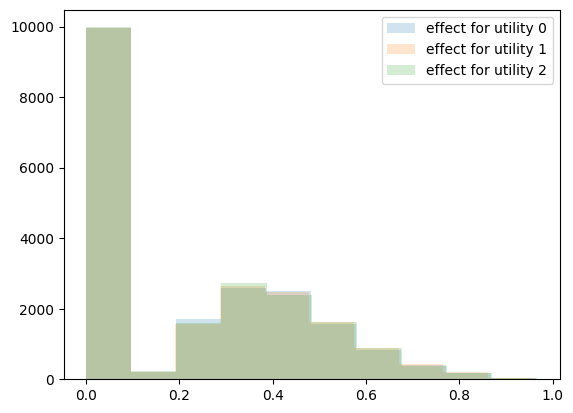

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from rumboost.metrics import mse, cross_entropy
np.random.seed(0)

def compute_levels(sp, betas):
    levels = np.zeros(len(sp))
    for i in range(len(sp) - 1):
        levels[i + 1] = levels[i] + (sp[i + 1] - sp[i]) * betas[i]
    return levels


def create_pw_linear_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    levels = compute_levels(sp, betas) + intercept
    f_x = levels[indices] + betas[indices] * (x - sp[indices])

    return f_x


def apply_linear_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_pw_linear_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data


def create_pw_constant_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    f_x = betas[indices] + intercept

    return f_x

def apply_constant_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_pw_constant_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data

def create_sinusoidal_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    f_x = np.sin(betas[indices] * x) + intercept
    return f_x

def apply_sinusoidal_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_sinusoidal_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data


def create_dataset(x_arr: np.ndarray, feature_names: list) -> pd.DataFrame:
    return pd.DataFrame({feature_names[i]: x_arr[:, i] for i in range(x_arr.shape[1])})


def generate_x(n, k, props_low=0.5, cut=0.5, deterministic=False):
    n_low = int(props_low * n)
    n_high = n - n_low
    if deterministic:
        x_low = np.linspace([0]*n_utility, [cut]*n_utility, n_low)
        x_high = np.linspace([cut]*n_utility, [1]*n_utility, n_high)
    else:
        x_low = np.random.uniform(0, cut, (n_low, k))
        x_high = np.random.uniform(cut, 1, (n_high, k))

    return np.concatenate([x_low, x_high], axis=0)

def create_functional_effects(x: np.ndarray, n_utility: int, n_socio_dem: int) -> np.ndarray:
    """
    Create functional effects for a given number of utilities and features per utility.
    """
    effects = np.zeros((x.shape[0], n_utility))
    random_permutations = [np.random.choice(n_socio_dem, size=(n_socio_dem - 1), replace=False) for _ in range(n_utility)]
    for i in range(n_utility):
        effects[:, i] = np.prod(x[:, random_permutations[i]], axis=1)
            
    return effects

def apply_functional_effects(x: np.ndarray, n_utility: int, n_socio_dem: int) -> pd.DataFrame:
    """
    Apply functional effects to the input data and return a DataFrame.
    """
    effects = create_functional_effects(x, n_utility, n_socio_dem)
    feature_names = [f"f{i}" for i in range(n_utility)]
    
    return pd.DataFrame(effects, columns=feature_names)

def add_alt_spec_features(dataset_transformed: pd.DataFrame, x_alt: np.ndarray, n_utility: int, coeff: list, n_socio_dem: int) -> pd.DataFrame:
    """
    Add alternative specific features to the transformed dataset.
    """
    
    for i in range(n_utility):
        dataset_transformed.iloc[:, i] += coeff[i] * x_alt[:, i + n_socio_dem]
    
    return dataset_transformed

def add_choice(row, u_idx, regression=False):
    u = np.array([np.sum(row[u_idx[i][0] : u_idx[i][1]]) for i in range(len(u_idx))])
    if regression:
        return u[0]
    else:
        return np.random.choice(u.shape[0], size=1, p=softmax(u))[0]

n_utility = 3 
regression = n_utility == 1
f_per_utility = 5
n_alt_spec = 1
n_socio_dem = 4
tot_features = n_socio_dem + n_utility * n_alt_spec
x_arr = generate_x(20000, tot_features, 0.5, 0.5)
x_arr_test = generate_x(10000, tot_features, 0.5, 0.5)
coeff = [-1, -1, -1]

feature_names = [f"f{i}" for i in range(tot_features)]

u_idx = [(n_alt_spec * i, n_alt_spec * (i+1)) for i in range(n_utility)]

y_plot = apply_functional_effects(x_arr, n_utility, n_socio_dem)
for i in range(n_utility):
    plt.hist(y_plot.iloc[:, i], label = f"effect for utility {i}", alpha = 0.2)
    plt.legend()

dataset = create_dataset(x_arr, feature_names)
dataset_transf = apply_functional_effects(x_arr, n_utility, n_socio_dem)
dataset_transf = add_alt_spec_features(dataset_transf, x_arr, n_utility, coeff, n_socio_dem)
dataset["choice"] = dataset_transf.apply(add_choice, axis=1, u_idx=u_idx, regression=regression)
dataset_test = create_dataset(x_arr_test, feature_names)
dataset_test_transf = apply_functional_effects(x_arr_test, n_utility, n_socio_dem)
dataset_test_transf = add_alt_spec_features(dataset_test_transf, x_arr_test, n_utility, coeff, n_socio_dem)
dataset_test["choice"] = dataset_test_transf.apply(add_choice, axis=1, u_idx=u_idx, regression=regression)

dataset.describe()

In [3]:
from models_wrapper import RUMBoost, TasteNet
from parser import parse_cmdline_args
from synthetic_experiment import gather_functional_intercepts, l1_distance

alt_spec_features = {i: [f"f{i+n_socio_dem}"] for i in range(n_utility)}
# alt_spec_features = {0: []}
socio_demo_chars = [f"f{i}" for i in range(n_socio_dem)]
X_train = dataset.drop(columns=["choice"])
X_val = dataset_test.drop(columns=["choice"])
y_train = dataset["choice"]
y_val = dataset_test["choice"]

In [4]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

In [7]:
socio_demo_chars

['f0', 'f1', 'f2', 'f3']

In [9]:
model.rum_structure

[{'variables': ['f4'],
  'utility': [0],
  'boosting_params': {'monotone_constraints_method': 'advanced',
   'max_depth': 1,
   'n_jobs': -1,
   'learning_rate': np.float64(0.1),
   'verbose': -1,
   'monotone_constraints': [0],
   'interaction_constraints': [[0]],
   'num_leaves': 31,
   'min_gain_to_split': 0.0,
   'min_sum_hessian_in_leaf': 0.001,
   'max_bin': 255,
   'min_data_in_bin': 3,
   'min_data_in_leaf': 20,
   'feature_fraction': 1.0,
   'bagging_fraction': 1.0,
   'bagging_freq': 0,
   'lambda_l1': 0.0,
   'lambda_l2': 0.0,
   'objective': 'binary'},
  'shared': False},
 {'variables': ['f5'],
  'utility': [1],
  'boosting_params': {'monotone_constraints_method': 'advanced',
   'max_depth': 1,
   'n_jobs': -1,
   'learning_rate': np.float64(0.1),
   'verbose': -1,
   'monotone_constraints': [0],
   'interaction_constraints': [[0]],
   'num_leaves': 31,
   'min_gain_to_split': 0.0,
   'min_sum_hessian_in_leaf': 0.001,
   'max_bin': 255,
   'min_data_in_bin': 3,
   'min_data

In [11]:
model = "RUMBoost"
args = parse_cmdline_args()
args.functional_intercept = True
args.functional_params = False
args.feature_fraction = 1.0
args.save_model = True
args.model = model
args.dataset = "synthetic"
args.learning_rate = 1
args.device = "cpu"
args.num_iterations = 1000

model = RUMBoost(
    alt_spec_features=alt_spec_features,
    socio_demo_chars=socio_demo_chars,
    num_classes=n_utility,
    args=args,
    )

# build dataloader
model.build_dataloader(X_train, y_train, X_val, y_val)

# fit model
best_train_loss, best_val_loss = model.fit()


# predict on the test set
preds, _, _ = model.predict(X_val)
loss_test = cross_entropy(preds, y_val)



/home/nicolas-salvade/panel-data/src/rumboost/rumboost.py:2680: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[1]------NCE value on train set : 1.0960
---------NCE value on test set 1: 1.0982
[11]-----NCE value on train set : 1.0776
---------NCE value on test set 1: 1.0985
Early stopping at iteration 4, with a best score on test set of 1.0980683121915873, and on train set of 1.071991809698029


In [15]:
model.model.boosters[0].dump_model()

{'name': 'tree',
 'version': 'v4',
 'num_class': 1,
 'num_tree_per_iteration': 1,
 'label_index': 0,
 'max_feature_idx': 0,
 'average_output': False,
 'feature_names': ['f4'],
 'monotone_constraints': [0],
 'feature_infos': {'f4': {'min_value': 3.684971655304459e-05,
   'max_value': 0.9999835555647097,
   'values': []}},
 'tree_info': [{'tree_index': 0,
   'num_leaves': 2,
   'num_cat': 0,
   'shrinkage': 0.1,
   'tree_structure': {'split_index': 0,
    'split_feature': 0,
    'split_gain': 28.234100341796875,
    'threshold': 0.11382951200775891,
    'decision_type': '<=',
    'default_left': True,
    'missing_type': 'None',
    'internal_value': 0,
    'internal_weight': 0,
    'internal_count': 20000,
    'left_child': {'leaf_index': 0,
     'leaf_value': 0.018354430379746836,
     'leaf_weight': 790.0000235438347,
     'leaf_count': 2370},
    'right_child': {'leaf_index': 1,
     'leaf_value': -0.0017810550198525243,
     'leaf_weight': 5876.666841804981,
     'leaf_count': 17630

In [16]:
# get learnt functional intercepts
learnt_fct_intercepts = gather_functional_intercepts(
    dataset, model, socio_demo_chars, n_utility
)
learnt_fct_intercepts_test = gather_functional_intercepts(
    dataset_test, model, socio_demo_chars, n_utility
)

# compute L1 distance between true and learnt functional intercepts
l1_distance_train = l1_distance(
    dataset_transf,
    learnt_fct_intercepts,
)
l1_distance_test = l1_distance(
    dataset_test_transf,
    learnt_fct_intercepts_test,
)

print(f"Best Train Loss: {best_train_loss}, Best Val Loss: {best_val_loss}")
print(f"Test Loss: {loss_test}")

Best Train Loss: 1.071991809698029, Best Val Loss: 1.0980683121915873
Test Loss: 1.0984120392058176


c:\Users\ucesnjs\anaconda32\envs\old_rumboost\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


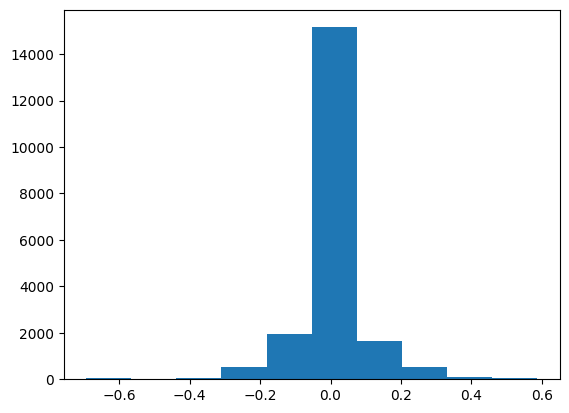

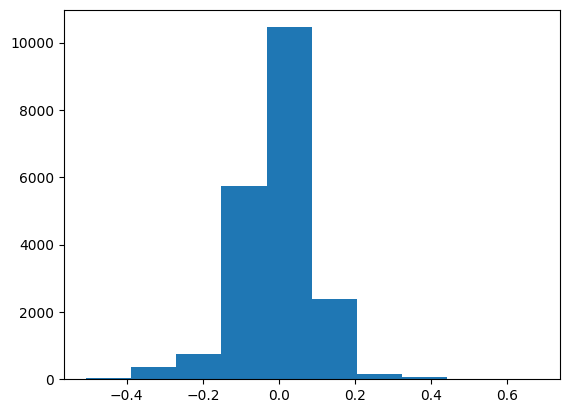

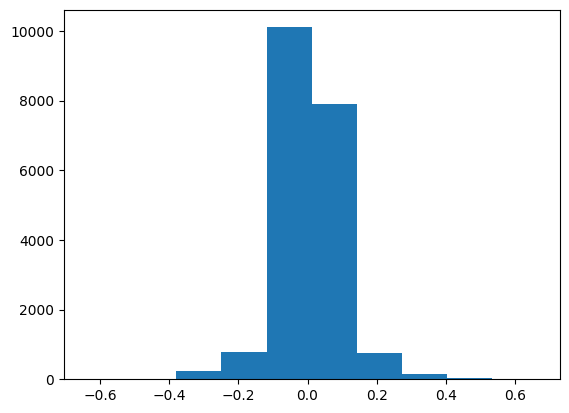

In [19]:
for i in range(n_utility):
    plt.figure()
    plt.hist(learnt_fct_intercepts[:,i])

In [20]:
model = "TasteNet"
args = parse_cmdline_args()
args.functional_intercept = True
args.functional_params = False
args.feature_fraction = 1.0
args.save_model = True
args.model = model
args.dataset = "synthetic"


model = TasteNet(
    alt_spec_features=alt_spec_features,
    socio_demo_chars=socio_demo_chars,
    num_classes=n_utility,
    num_latent_vals=None,
    args=args,
)

# build dataloader
model.build_dataloader(X_train, y_train, X_val, y_val)

# fit model
best_train_loss, best_val_loss = model.fit()


# predict on the test set
preds, _, _ = model.predict(X_val)
loss_test = mse(preds, y_val)



/home/nicolas-salvade/miniforge3/envs/share/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/home/nicolas-salvade/miniforge3/envs/share/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 0])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (0) must match the size of tensor b (256) at non-singleton dimension 1